In [ ]:
# Last amended: 15th August, 2019
# My folder: /home/ashok/Documents/spark/2.bike_sharing_dataset
# VM: lubuntu_spark.7z
# Ref: https://docs.databricks.com/spark/latest/mllib/decision-trees.html#gbt-regression-using-mllib-pipelines

## Analyzing a bike sharing dataset

### Objectives
----------
	To demonstrate creating an ML Pipeline to i) preprocess
	a dataset, ii) train a Machine Learning model, and iii) make
	predictions.

### Data:
-----
	The dataset contains bike rental info from
	2011 and 2012 in the Capital bikeshare system, plus
	additional relevant information such as weather.
	This dataset is from Fanaee-T and Gama (2013) and
	is hosted by the UCI Machine Learning Repository.

Fields :
	Features:
		- instant: record index; Serial number
		- dteday : date
		- season : season (1:springer, 2:summer, 3:fall, 4:winter)
		- yr : year (0: 2011, 1:2012) Format: yyyy-mm-dd
		- mnth : month ( 1 to 12)
		- hr : hour (0 to 23)
		- holiday : weather day is holiday or not (extracted from [Web Link])
		- weekday : day of the week
		- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
		+ weathersit : 1 (clear), 2 (mist), 3(light snow), 4 (heavy rain)
		- temp : Normalized temperature in Celsius.
		- atemp: Normalized feeling temperature in Celsius.
		- hum: Normalized humidity. 
		- windspeed: Normalized wind speed.
	Target or label fields:
		- casual: count of casual users         
		- registered: count of registered users
		- cnt: count of total rental bikes including both casual and registered
	

### Goal:
------
	We want to learn to predict bike rental
	counts (per hour) from information such as day of
	the week, weather, season, etc. Having good
	predictions of customer demand allows a business or
	service to prepare and increase supply as needed.
	Our target will be:  'cnt'

### Approach:
----------
	 We will use Spark ML Pipelines, which help
	users piece together parts of a workflow such as
	feature processing and model training. We will also
	demonstrate model selection (a.k.a. hyperparameter
	tuning) using Cross Validation in order to fine-tune
	and improve our ML model.

In [1]:
# 1. Increase the width of notebook 
#    to display all columns of data
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# 1.1 Show multiple outputs of a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Explore data

In [5]:
# 2. Read, transform and understand the data
#      https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.csv
#    pyspark creates a spark-session variable: spark
df = spark.read.csv(
                   path = "hdfs://localhost:9000/user/ashok/data_files/hour.csv",   # path to hadoop
                   header = True,
                   inferSchema= True,           # Infer datatypes automatically
                   sep = "," ,                  # Can be any character (check \t)
                   dateFormat = "yyyy-mm-dd"    # Automatic transformation to 'timestamp' format
                   )


In [6]:
# 2.1 What is the nature of df:
type(df)                     # pyspark.sql.dataframe.DataFrame

pyspark.sql.dataframe.DataFrame

In [5]:
# 2.2 Show data. Note that 'dteday' is timestamp type
df.show(3)

+-------+-------------------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+
|instant|             dteday|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed|casual|registered|cnt|
+-------+-------------------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+
|      1|2011-01-01 00:00:00|     1|  0|   1|  0|      0|      6|         0|         1|0.24|0.2879|0.81|      0.0|     3|        13| 16|
|      2|2011-01-01 00:00:00|     1|  0|   1|  1|      0|      6|         0|         1|0.22|0.2727| 0.8|      0.0|     8|        32| 40|
|      3|2011-01-01 00:00:00|     1|  0|   1|  2|      0|      6|         0|         1|0.22|0.2727| 0.8|      0.0|     5|        27| 32|
+-------+-------------------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+
only showing top 3 rows



In [7]:
# 2.3 We also cache the data so that we only read it from disk once.
df.cache()
df.is_cached            # Checks if df is cached

DataFrame[instant: int, dteday: timestamp, season: int, yr: int, mnth: int, hr: int, holiday: int, weekday: int, workingday: int, weathersit: int, temp: double, atemp: double, hum: double, windspeed: double, casual: int, registered: int, cnt: int]

True

In [7]:
# 2.4 There is NO 'df.shape'  command.
#         Instead, do as follows:

#     a) How many rows?

df.count()                # 17379

#     b) How many columns?

len(df.columns)

#	c) Both together:

df.count(), len(df.columns)


17379

17

(17379, 17)

In [8]:
# 3. The dataset has three target/label columns.
#      All three are related. So we can consider only
#      one of them:
#	Label columns are:
#		    casual: count of casual users
#		    registered: count of registered users
#		    cnt: count of total rental bikes including both casual and registered
#                (in fact cnt has some very direct relationship with casual and registered)
#    We will concern ourselves with only 'cnt'. Also drop 'dteday' columns (ie date columns)
# 3.1
cols = df.columns
cols         # It is a list of 17 elements

['instant',
 'dteday',
 'season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'cnt']

In [9]:
# 3.2 Show database in parts:
df.select(cols[:10]).show(3)
df.select(cols[10:]).show(3)

+-------+-------------------+------+---+----+---+-------+-------+----------+----------+
|instant|             dteday|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|
+-------+-------------------+------+---+----+---+-------+-------+----------+----------+
|      1|2011-01-01 00:00:00|     1|  0|   1|  0|      0|      6|         0|         1|
|      2|2011-01-01 00:00:00|     1|  0|   1|  1|      0|      6|         0|         1|
|      3|2011-01-01 00:00:00|     1|  0|   1|  2|      0|      6|         0|         1|
+-------+-------------------+------+---+----+---+-------+-------+----------+----------+
only showing top 3 rows

+----+------+----+---------+------+----------+---+
|temp| atemp| hum|windspeed|casual|registered|cnt|
+----+------+----+---------+------+----------+---+
|0.24|0.2879|0.81|      0.0|     3|        13| 16|
|0.22|0.2727| 0.8|      0.0|     8|        32| 40|
|0.22|0.2727| 0.8|      0.0|     5|        27| 32|
+----+------+----+---------+------+----------+---+
on

In [10]:
# 3.3  Note that earlier df is being 'overwritten'
#         instant: Merely serial number
#        dteday: Date in the form: 2011-01-03
#                In a sep col, 2011, is coded as 0 and 2012 as 1
#			     All other date related inf is available in other cols.
#			     So drop this column

# 3.3.1 Which columns to dorp?

columns_to_drop = ['instant', 'dteday','casual','registered']
df.select(columns_to_drop).show(3)


+-------+-------------------+------+----------+
|instant|             dteday|casual|registered|
+-------+-------------------+------+----------+
|      1|2011-01-01 00:00:00|     3|        13|
|      2|2011-01-01 00:00:00|     8|        32|
|      3|2011-01-01 00:00:00|     5|        27|
+-------+-------------------+------+----------+
only showing top 3 rows



In [11]:
# 3.3.2 Multiple columns must be specified in string form, as:
#            df.drop("col1", "col2","col3")  AND not as a list.
#           Use unpack operator (*), to unpack the list.
#           Unpack operator is generally used as arguments to a
#           function, as foo(*args).

df= df.drop(*columns_to_drop)

In [12]:
# OR, drop individually:
df = df.drop("instant").drop("dteday").drop("casual").drop("registered")

In [13]:
# 3.3 Show database structure.
#         Note that some columns are of type 'int'
#         and other of type 'float'

df.printSchema()
df.dtypes

root
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- hr: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- cnt: integer (nullable = true)



[('season', 'int'),
 ('yr', 'int'),
 ('mnth', 'int'),
 ('hr', 'int'),
 ('holiday', 'int'),
 ('weekday', 'int'),
 ('workingday', 'int'),
 ('weathersit', 'int'),
 ('temp', 'double'),
 ('atemp', 'double'),
 ('hum', 'double'),
 ('windspeed', 'double'),
 ('cnt', 'int')]

In [14]:
# 4.  Cast all int columns using Spark SQL to a numeric type (DoubleType).
#      Ref:  http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html#module-pyspark.sql.functions

# 4.1 Call necessary libraries
# 4.1.1 col() returns a Column (values) based on a given
#             column name. col() is used within select statement
#             or within withColumn()  

from pyspark.sql.functions import col

In [15]:
# Just try. All three work.
df.select(col("cnt")).show(3)
df.select(df["cnt"]).show(3)
df.select("cnt").show(3)

+---+
|cnt|
+---+
| 16|
| 40|
| 32|
+---+
only showing top 3 rows

+---+
|cnt|
+---+
| 16|
| 40|
| 32|
+---+
only showing top 3 rows

+---+
|cnt|
+---+
| 16|
| 40|
| 32|
+---+
only showing top 3 rows



In [16]:
# 4.1.2 Import class 'DoubleType' that represents double
#       data type:

from pyspark.sql.types import DoubleType

In [17]:
# 4.2 Casting an individual column:
#        withColumn()  returns a new DataFrame by adding a
#        column or replacing the existing column that has the
#        same name. So here, we replace:
#    Syntax:
#          withColumn(colName, col)[source]
#             Returns a new DataFrame by adding a column or replacing 
#                 the existing column that has the same name.

df = df.withColumn("cnt", col("cnt").cast(DoubleType()))

In [18]:
# 4.3 This fails:
df["cnt"].show()

TypeError: 'Column' object is not callable

In [19]:
df.dtypes

[('season', 'int'),
 ('yr', 'int'),
 ('mnth', 'int'),
 ('hr', 'int'),
 ('holiday', 'int'),
 ('weekday', 'int'),
 ('workingday', 'int'),
 ('weathersit', 'int'),
 ('temp', 'double'),
 ('atemp', 'double'),
 ('hum', 'double'),
 ('windspeed', 'double'),
 ('cnt', 'double')]

In [20]:
# But this succeeds. Cast to double:
df = df.withColumn("cnt", df["cnt"].cast(DoubleType()))

In [21]:
# 4.3 We will now cast the rest of  columns into doubletype
#         in one go as:
# 4.3.1
df.dtypes
int_cols =   [  i[0] for i in df.dtypes if i[1] == 'int' ] 
int_cols


[('season', 'int'),
 ('yr', 'int'),
 ('mnth', 'int'),
 ('hr', 'int'),
 ('holiday', 'int'),
 ('weekday', 'int'),
 ('workingday', 'int'),
 ('weathersit', 'int'),
 ('temp', 'double'),
 ('atemp', 'double'),
 ('hum', 'double'),
 ('windspeed', 'double'),
 ('cnt', 'double')]

['season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit']

In [22]:
# 4.3.2
for l in int_cols:
    df = df.withColumn(l, col(l).cast(DoubleType()))

df.dtypes    

[('season', 'double'),
 ('yr', 'double'),
 ('mnth', 'double'),
 ('hr', 'double'),
 ('holiday', 'double'),
 ('weekday', 'double'),
 ('workingday', 'double'),
 ('weathersit', 'double'),
 ('temp', 'double'),
 ('atemp', 'double'),
 ('hum', 'double'),
 ('windspeed', 'double'),
 ('cnt', 'double')]

In [23]:
# 5. Split the dataset randomly into 70% for
#    training and 30% for testing.
train, test = df.randomSplit([0.7, 0.3])

In [24]:
# 5.1
train.count()/df.count()
test.count()/df.count()

0.7056792680821682

0.29432073191783187

In [25]:
# 5.2 Check missing values:
#     https://stackoverflow.com/questions/44413132/count-the-number-of-missing-values-in-a-dataframe-spark
from pyspark.sql.functions import col,sum
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()

+------+---+----+---+-------+-------+----------+----------+----+-----+---+---------+---+
|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp|atemp|hum|windspeed|cnt|
+------+---+----+---+-------+-------+----------+----------+----+-----+---+---------+---+
|     0|  0|   0|  0|      0|      0|         0|         0|   0|    0|  0|        0|  0|
+------+---+----+---+-------+-------+----------+----------+----+-----+---+---------+---+



In [ ]:
# 5.3 Scatter plot of numeric columns:

# See para #11 below (at the end of code)

In [ ]:
################### BB. Process data  #######################


## VectorAssembler: 
This concatenates all feature columns, whatever type,  into a single feature vector<br>
in a new column "rawFeatures".<br>
	Ref: https://spark.apache.org/docs/latest/ml-features.html#vectorassembler <br>
	VectorAssembler <br>
	Also see: <br>
	https://stackoverflow.com/questions/38236389/understanding-output-of-vectorassembler-spark  <br>
	
	VectorAssembler is a transformer that combines a given
	list of columns into a single vector column. It is useful
	for combining raw features and features generated by
	different feature transformers into a single feature vector,
	in order to train ML models like logistic regression and
	decision trees. VectorAssembler accepts the following input
	column types: all numeric types, boolean type, and vector type.
	In each row, the values of the input columns will be
	concatenated into a vector in the specified order.
	
	Examples
	
	Assume that we have a DataFrame with the columns
	id, hour, mobile, userFeatures, and clicked:
	
	 id | hour    | mobile    | userFeatures            | clicked
	----|---------|-----------|-------------------------|---------
	 0  | 18      | 1.0       | [0.0, 10.0, 0.5]        | 1.0
	
	
	
	userFeatures is a vector column that contains three user features.
	We want to combine hour, mobile, and userFeatures into a
	single feature vector called features and use it to predict
	clicked or not. If we set VectorAssembler’s input columns to
	 hour, mobile, and userFeatures and output column to features,
	after transformation we should get the following DataFrame:
	
	 id | hour    | mobile     | userFeatures        | clicked    | features
	----|---------|----------- |------------------- -|------------|--------------------------------------
	 0  | 18      | 1.0        | [0.0, 10.0, 0.5]    | 1.0        | [18.0, 1.0, 0.0, 10.0, 0.5]
	


In [26]:
# 6.1 Import VectorAssembler
from pyspark.ml.feature import VectorAssembler

In [27]:
# 6.2 Which columns to concatenate?
featuresCols = df.columns
featuresCols
# 6.3 Get only predictors.
#     .remove()' is a python list method
featuresCols.remove('cnt')
featuresCols

['season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'cnt']

['season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed']

In [28]:
# 6.4   Create an instance of VectorAssembler class.
#          This object will be used to transfrom data farme,
#           as: vectorassembler.fit(df)

vectorassembler = VectorAssembler(
                                  inputCols=featuresCols,
                                  outputCol="rawFeatures"
                                 )

In [29]:
vectorassembler

VectorAssembler_19923e64a036

In [30]:
# 6.5 Transform and  have a look at the output.
#     Note that we will not be using the resulting
#     'output' anywhere as we will be using pipeline.
#     This code is merely for demo
output = vectorassembler.transform(train)
output.show(3)
# 6.5.1 Just see the 'rawFeatures' column
output.select('rawFeatures').show(3,truncate=False)


+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+----+--------------------+
|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed| cnt|         rawFeatures|
+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+----+--------------------+
|   1.0|0.0| 1.0|0.0|    0.0|    0.0|       0.0|       1.0|0.04|0.0758|0.57|   0.1045|22.0|[1.0,0.0,1.0,0.0,...|
|   1.0|0.0| 1.0|0.0|    0.0|    0.0|       0.0|       1.0| 0.1|0.0758|0.42|   0.3881|25.0|[1.0,0.0,1.0,0.0,...|
|   1.0|0.0| 1.0|0.0|    0.0|    0.0|       0.0|       1.0|0.16|0.1818| 0.8|   0.1045|33.0|[1.0,0.0,1.0,0.0,...|
+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+----+--------------------+
only showing top 3 rows

+---------------------------------------------------------+
|rawFeatures                                              |
+---------------------------------------------------------+
|[1.

# VectorIndexer

Ref: https://spark.apache.org/docs/latest/ml-features.html#vectorindexer <br>

VectorIndexer helps index categorical features in datasets of Vectors.<br>
It can both automatically decide which features are categorical and <br>
convert original values to category indices. Specifically, it does the following: <br>

    Take an input column of type Vector and a parameter maxCategories.
    Decide which features should be categorical based on the number
    of distinct values, where features with at most maxCategories
    are declared categorical.

    Compute 0-based category indices for each categorical feature.
    Index categorical features and transform original feature values
    to indices. E.g.: Feature 0 has unique values {-1.0, 0.0}, and
    feature 1 values {1.0, 3.0, 5.0}. If maxCategories = 2, then
    feature 0 will be declared categorical and use indices {0, 1},
    and feature 1 will be declared continuous.

    Features with at most 'maxCategories' are declared categorical.

Indexing categorical features allows algorithms such as Decision Trees <br>
and Tree Ensembles to treat categorical features appropriately, improving <br>
performance. 

In the case of our data, following columns should be categorical:

- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit : 1 (clear), 2 (mist), 3(light snow), 4 (heavy rain)
- season : season (1:springer, 2:summer, 3:fall, 4:winter)

### StringIndexer vs VectorIndexer
Ref:  https://stackoverflow.com/questions/44195535/what-is-stringindexer-vectorindexer-and-how-to-use-them <br>

	String Indexer - Use it if you want the ML algorithm
	 to identify column as categorical variable or if want
	to convert the textual data to numeric data keeping
	the categorical context. For example, converting
	 days(Monday, Tuesday...) to numeric representation.
     Same as sklearn's LabelEncoder()

	Vector Indexer- use this if we do not know the types of
	data incoming. so we leave the logic of differentiating
	between categorical and non categorical data to the
	algorithm using Vector Indexer.
	e,g - Data coming from 3rd Party API, where data is hidden
	and is ingested directly to the training model.

### OneHotEncoder vs VectorIndexer
Ref: https://stackoverflow.com/questions/54222750/addressing-categorical-features-with-one-hot-encoding-and-vector-assembler-vs-ve <br>
The two are totally different. VectorIndexer will reindex the indicies of a categorical column. It will start from 0 rather than any other number. And at the same time a metadata will be added that the column is categorical. In tree-based algorithms such transformation and metadata are helpful (for example, column will not be bifurcated at 1.5). <br>
OneHotEncoding will be useful in all cases of machine learning whether tree-based or not. Thus VectorIndexing is not a replacement for OneHotEncoding.

In [34]:
# 7.1
#     Identify categorical features and indexes them.
#     Note that columns need not be 'int' type.

from pyspark.ml.feature import VectorIndexer

# 7.2  Instantiate the object first
vectorindexer = VectorIndexer(inputCol="rawFeatures",
                              outputCol="features",
                              maxCategories=7
                              )

In [35]:
# 7.3 Before using pipelines, let us see what would
#     be the output of transformation.

model = vectorindexer.fit(output)          # 'output' is from VentorAssembler
data = model.transform(output)

# 7.4 Look at the result
data.select('rawFeatures', 'features').show(3, truncate= False)

# 7.5 And how categorical mappings have been conducted?
model.categoryMaps

+---------------------------------------------------------+---------------------------------------------------------+
|rawFeatures                                              |features                                                 |
+---------------------------------------------------------+---------------------------------------------------------+
|[1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.04,0.0758,0.57,0.1045]|[0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0758,0.57,0.1045]|
|[1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.1,0.0758,0.42,0.3881] |[0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0758,0.42,0.3881] |
|[1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.16,0.1818,0.8,0.1045] |[0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.16,0.1818,0.8,0.1045] |
+---------------------------------------------------------+---------------------------------------------------------+
only showing top 3 rows



{0: {1.0: 0, 2.0: 1, 3.0: 2, 4.0: 3}, 5: {0.0: 0, 5.0: 5, 1.0: 1, 6.0: 6, 2.0: 2, 3.0: 3, 4.0: 4}, 1: {0.0: 0, 1.0: 1}, 6: {0.0: 0, 1.0: 1}, 7: {1.0: 0, 2.0: 1, 3.0: 2, 4.0: 3}, 4: {0.0: 0, 1.0: 1}}

################### CC. Perform Modeling  #####################

In [36]:
# 8. Call gradient boosting regression and other libraries
#    Spark ML API: https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark-ml-package

from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
import time

In [37]:
help(GBTRegressor)

Help on class GBTRegressor in module pyspark.ml.regression:

class GBTRegressor(pyspark.ml.wrapper.JavaEstimator, pyspark.ml.param.shared.HasFeaturesCol, pyspark.ml.param.shared.HasLabelCol, pyspark.ml.param.shared.HasPredictionCol, pyspark.ml.param.shared.HasMaxIter, GBTParams, pyspark.ml.param.shared.HasCheckpointInterval, pyspark.ml.param.shared.HasStepSize, pyspark.ml.param.shared.HasSeed, pyspark.ml.util.JavaMLWritable, pyspark.ml.util.JavaMLReadable, TreeRegressorParams)
 |  GBTRegressor(featuresCol='features', labelCol='label', predictionCol='prediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, subsamplingRate=1.0, checkpointInterval=10, lossType='squared', maxIter=20, stepSize=0.1, seed=None, impurity='variance', featureSubsetStrategy='all')
 |  
 |  `Gradient-Boosted Trees (GBTs) <http://en.wikipedia.org/wiki/Gradient_boosting>`_
 |  learning algorithm for regression.
 |  It supports both continuous and categorical

In [38]:
## Instantiating Objects
# 9.1 Instantiate the regressor object
#     Takes the "features" column and learns to predict "cnt"

gbt = GBTRegressor(labelCol="cnt")


### Model selection (a.k.a. hyperparameter tuning)

An important task in ML is model selection, or using data to find the best model or parameters for a given task. This is also called tuning. Tuning may be done for individual Estimators such as LogisticRegression, or for entire Pipelines which include multiple algorithms, featurization, and other steps. Users can tune an entire Pipeline at once, rather than tuning each element in the Pipeline separately.

MLlib supports model selection using tools such as _CrossValidator_ and _TrainValidationSplit_. These tools require the following items:

-    Estimator: algorithm or Pipeline to tune
-    Set of ParamMaps: parameters to choose from, sometimes called a “parameter grid” to search over
-    Evaluator: metric to measure how well a fitted Model does on held-out test data

At a high level, these model selection tools work as follows:

-    They split the input data into separate training and test datasets.
-    For each (training, test) pair, they iterate through the set of ParamMaps:
    -        For each ParamMap, they fit the Estimator using those parameters, get the fitted Model, and evaluate the Model’s performance using the _Evaluator_.
-   They select the Model produced by the best-performing set of parameters.

The _Evaluator_ can be a _RegressionEvaluator_ for regression problems, a _BinaryClassificationEvaluator_ for binary data, or a _MulticlassClassificationEvaluator_ for multiclass problems. The default metric used to choose the best ParamMap can be overridden by the setMetricName method in each of these evaluators.

To help construct the parameter grid, users can use the _ParamGridBuilder_ utility.

In [39]:
# 9.2 Define and build grid of parameters
#     Model tuning: https://spark.apache.org/docs/2.2.0/ml-tuning.html
#     ParamGridBuilder API: https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder

# Try deoth of 2 and 5. Iterations of 10 and 100
paramGrid = ParamGridBuilder()\
                         .addGrid(gbt.maxDepth, [2, 5]) \
                         .addGrid(gbt.maxIter, [10, 100])\
                         .build()


In [40]:
# 9.3 Instantiate evaluator object
#     We are performing cross validation
#     Results of prediction are made on held-back data
#     during cross-validation
#     Given a fitted gbt object, it
#     API: https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator

evaluator = RegressionEvaluator(
                               metricName="rmse",                   # This is default
                               labelCol="gbt.getLabelCol()",          # Actual col value
                               predictionCol=gbt.getPredictionCol() # predicted col value
                               )

In [41]:
# 9.4 Create CV object:
#     Cross Validator API: https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator
cv = CrossValidator(estimator=gbt,
                    evaluator=evaluator,
                    estimatorParamMaps=paramGrid
                    )

### Pipeline
https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.Pipeline <br>
A simple pipeline, which acts as an estimator. A Pipeline consists of a sequence of stages, each of which is either an _Estimator_ or a _Transformer_. When _Pipeline.fit()_ is called, the stages are executed in order. If a stage is an _Estimator_, its _Estimator.fit()_ method will be called on the input dataset to fit a model. Then the model, which is a transformer, will be used to transform the dataset as the input to the next stage. If a stage is a _Transformer_, its _Transformer.transform()_ method will be called to produce the dataset for the next stage. The fitted model from a Pipeline is a PipelineModel, which consists of fitted models and transformers, corresponding to the pipeline stages. If stages is an empty list, the pipeline acts as an identity transformer.

In [42]:
# 9.5 Instantiate pipeline objects
#     Pipeline API: https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.Pipeline

pipeline = Pipeline(stages=[vectorassembler, vectorindexer, cv])

In [43]:
# 10. Run the pipeline. This will run complete pipe
#     including transform() methods of vectorassembler & vectorindexer
#     but transform() method of cv is not run. For cv,
#     it is just modeling and fitting; no transformation.
#    CONSUMES LOTS OF MEMORY. THINGS MAY SLOW DOWN
#    OR CONNECTIONS MAY BREAK

start = time.time()
pipelineModel = pipeline.fit(train)
end = time.time()
(end - start)/60           # Takes 15 minutes


15.470971667766571

############# DD. Predictions & evaluation  ######################

In [44]:
# 10.1 Make predictions on test data using the best model
#      But for pipeline, we would have to separately process
#     'test' data first

predictions = pipelineModel.transform(test)
type(predictions)               # Spark Dataframe
predictions.columns

pyspark.sql.dataframe.DataFrame

['season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'cnt',
 'rawFeatures',
 'features',
 'prediction']

In [45]:
# 10.2 Show all columns including predicted column
#      featuresCols: See para 6.2 above

predictions.select("cnt", "prediction", *featuresCols).show(4)

+----+------------------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+
| cnt|        prediction|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed|
+----+------------------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+
|17.0|   75.822301863756|   1.0|0.0| 1.0|0.0|    0.0|    0.0|       0.0|       2.0|0.46|0.4545|0.88|   0.2985|
| 7.0| 12.06072832961763|   1.0|0.0| 1.0|0.0|    0.0|    1.0|       1.0|       1.0|0.06|0.0606|0.41|    0.194|
| 5.0|20.498667425402143|   1.0|0.0| 1.0|0.0|    0.0|    1.0|       1.0|       1.0|0.22| 0.197|0.44|   0.3582|
|13.0|   24.215032894854|   1.0|0.0| 1.0|0.0|    0.0|    4.0|       1.0|       1.0|0.26|0.2273|0.56|   0.3881|
+----+------------------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+
only showing top 4 rows



In [46]:
# 10.3 Evaluate results
# Ref: http://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator
# Create evaluator object.  class is, as:
#  RegressionEvaluator(self, predictionCol="prediction", labelCol="label", metricName="rmse")
# 10.4
eval = RegressionEvaluator(predictionCol="prediction",
                           labelCol = 'cnt',
                            metricName="rmse"
                          )

In [47]:
# 10.5
rmse = eval.evaluate(predictions)
# 10.6
print ("RMSE on our test set: %g" % rmse)

RMSE on our test set: 44.1445


################### I am done ###################

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

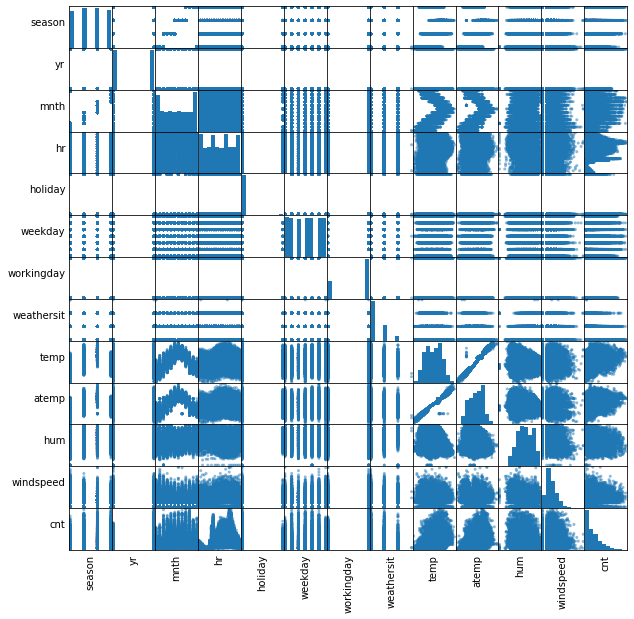

In [48]:
# 11. Scatter matrix among numeric columns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 11.1 Take a sample
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = df.select(numeric_features).sample(False, 0.6).toPandas()

# 11.2 Plot now
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())